# Capstone Project Week 1 Assignment

# Tornados and Trailer Parks

It is a well-known fact that when a tornado touches down the first thing it does is ask for 
directions to the nearest trailer park.  This is an unfortunate thing for people who live in trailer 
parks (as I did when I was a kid).  

There is a dataset out there that contains statistical information on every tornado in the US from 
1950 to 2015.  So it occurred to me that this data might be useful in determining the best place to 
build a trailer park in the US.

Now I have come to understand from reputable sources that tornados are spawned as a result of pre-
existing conditions.  They don't actually get to choose where they are going to touchdown.  So they
can't in a targeted way just drop in on a specific trailer park.

Therefore, there must exist some optimal location to build a trailer park which is removed from the
areas where tornados frequently spawn.

Our goal in this effort is to find that sweet spot if.  This information should prove invaluable not 
only to developers who are looking to build new trailer parks, but to trailer owners who are looking 
for a place to park them.

# Import our tornados .csv file into a pandas dataset

In [73]:
import pandas as pd

df = pd.read_csv (r'Capstone/Tornadoes_SPC_1950to2015.csv')

df.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,fat,loss,closs,slat,slon,elat,elon,len,wid,fc
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,...,0,6.0,0.0,38.77,-90.22,38.83,-90.03,9.5,150,0
1,2,1950,1,3,1/3/1950,11:55:00,3,IL,17,2,...,0,5.0,0.0,39.10,-89.30,39.12,-89.23,3.6,130,0
2,3,1950,1,3,1/3/1950,16:00:00,3,OH,39,1,...,0,4.0,0.0,40.88,-84.58,0.00,0.00,0.1,10,0
3,4,1950,1,13,1/13/1950,5:25:00,3,AR,5,1,...,1,3.0,0.0,34.40,-94.37,0.00,0.00,0.6,17,0
4,5,1950,1,25,1/25/1950,19:30:00,3,MO,29,2,...,0,5.0,0.0,37.60,-90.68,37.63,-90.65,2.3,300,0


So the fields in this dataset are as follows:
om = tornado number within a given year
yr = year
mo = month
dy = day
date = date in MM/DD/YYYY format
time = time of tornado 'birth'
tz = time zone
st = State
stf = a numeric code for the state (we'll drop this column as we don't need it)
stn = the number of this tornado in it's home state in a given year
mag = magnitude of tornado on the EF scale (F0 - F5)
inj = number of injuries
fat = number of fatalities
loss = property loss where 1 <= $50, 2 <= $500, 3 <= $5,000, 4 <= $50,000, 5 <= $500,000 and so on.
closs = crop loss
slat = starting latitude
slon = starting longitude
elat = ending latitude
elon = ending longitude (not to be confused with Elon Musk)
len = length in miles
wid = width in yards
fc = a composite code that contains info on multiple states affected.  Earlier entries lack this so we will drop it.

# Drop the columns we don't need

In [74]:
df = df.drop(["stf", "fc"], axis=1)

df.head()

,om,yr,mo,dy,date,time,tz,st,stn,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,1,3,3,0,6.0,0.0,38.77,-90.22,38.83,-90.03,9.5,150
1,2,1950,1,3,1/3/1950,11:55:00,3,IL,2,3,3,0,5.0,0.0,39.10,-89.30,39.12,-89.23,3.6,130
2,3,1950,1,3,1/3/1950,16:00:00,3,OH,1,1,1,0,4.0,0.0,40.88,-84.58,0.00,0.00,0.1,10
3,4,1950,1,13,1/13/1950,5:25:00,3,AR,1,3,1,1,3.0,0.0,34.40,-94.37,0.00,0.00,0.6,17
4,5,1950,1,25,1/25/1950,19:30:00,3,MO,2,2,5,0,5.0,0.0,37.60,-90.68,37.63,-90.65,2.3,300


# How many tornados in our dataframe?

In [75]:
df.shape

(60114, 20)

Hmmm...  Sixty thousand tornados.  If we are going to plot these on a map it's going to be pretty 
cluttered.  In fact we won't be able to see much else other than the black dots marking the tornados.

So perhaps we should group these tornados into clusters of tornados that occured in close proximity 
with each other, then plot the centerpoint of those clusters.

In AI we typically use a statistical method called k-means clustering to produce groupings like that.
In k-means clustering we group tornados (in this case) around a central point for each cluster that
is chosen to minimize the sum of the distances between the cluster center point and each of the 
tornados in that given cluster.  But how many clusters should we be creating?

If we created sixty thousand clusters - one for each tornado, the distance between the cluster 
center and the tornado would be zero.  So that would be a good fit for the data.  But then we lose
the whole reason we wanted to cluster in the first place because we would still have sixty thousand 
points to plot on our map.

So part of it comes down to the aesthetics of the map.  We don't want too few clusters (three or four
wouldn't make for an effective map.)  On the other hand we don't want too many.  So from an asthetics
viewpoint the correct number of clusters is probably somewhere between a hundred and a thousand.

But it's not all about aesthetics either.  We want to select a number of clusters that accurately
reflects the geo locations of the tornados while preserving the integrity of the data by not over-
averaging.

We will come back to picking the optimum number of clusters later.  Let's get started by setting up
and training our k-means engine.

# Import helpful libraries

In [76]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

# Create a dataset that contains only the starting latitude and longitude

In [77]:
latlong = df[['slat', 'slon']].copy()
latlong.head()

,slat,slon
0,38.77,-90.22
1,39.10,-89.30
2,40.88,-84.58
3,34.40,-94.37
4,37.60,-90.68


In [78]:
latlong.shape

(60114, 2)

So we now have two datasets.  The first one contains statistical information on all the 
tornados that ocurred in the US between 1950 and 2015.  The second dataset contains
only the starting latitude and longitude for each tornado which will be helpful for
plotting points on a map.

In week 2 we will pare down the number of events to something more suitable for
plotting on a map by using a k-means model to group each tornado into clusters of 
tornados that spawned at or near the same points.  We will then find and plot the 
centers of those clusters instead of plotting each individual tornado.

This data will be useful information for anybody looking to build a trailer park,
but could also be a life saver for people who own trailers and are looking for 
places to park them.

# End of Capstone Project Week 1 Assignment

# Capstone Project Week 2 Assignment

# Let's plot that just for the fun of it

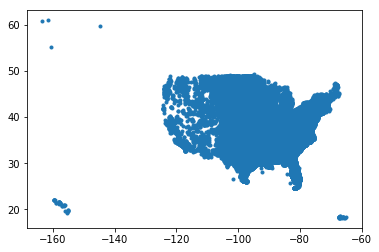

In [71]:
p = plt.scatter(latlong.iloc[:, 1], latlong.iloc[:, 0], marker='.')

plt.show()

Just as we suspected, that's pretty dense data.  We definately need to do some clustering before we 
overlay this on our map.

Fine, so now back to the question of the optimal number of clusters.

There is a way to figue out the optimal number.  But for now let's just set up a k-means model and 
train it on our data using an arbitrary 100 clusters (just to get everything working).

In [52]:
k_means = KMeans(init = "k-means++", n_clusters = 100, n_init = 12)


So in that line we set our number of clusters to 100 and n_init to 12.  n_init tells the 
model how many times it needs to iterate the calculations for each cluster, moving the 
center on each iteration in order to find the minimum average deviation of each tornado
from the cluster center.  In other words 12 iterations should be enough to find the 
optimum center of each of our 100 clusters.

Now it's time to fit our data to the k-means model.  With 60 thousand tornados, 100 
clusters and 12 iterations per cluster this may take a while.  It takes about 5 minutes
on my Windows 10 PC.  It would be faster on my Ubuntu box but I have that one torn apart.

In [53]:
k_means.fit(latlong)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# It worked!  Let's see where it put the cluster centers.

Let's grab the labels for each point in the model using KMeans' .labels_ attribute and 
save it as k_means_labels

In [54]:
k_means_labels = k_means.labels_
k_means_labels

array([93, 45, 44, ..., 68, 34, 14])

We will also get the coordinates of the cluster centers using KMeans' .cluster_centers_ and 
save it as k_means_cluster_centers

In [55]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[  30.07506897,  -82.14189655],
       [  39.40973422,  -99.96883721],
       [  38.66424658,  -87.37322679],
       [  29.63186047,  -99.14645995],
       [  40.18576389,  -75.08956019],
       [  47.17924419, -110.05436047],
       [  35.30620733,  -95.27993679],
       [  42.9697619 ,  -95.54122024],
       [  33.8030687 ,  -88.52027481],
       [  36.93333333, -114.23985507],
       [  21.09341463, -157.56731707],
       [  47.40619718, -101.56223592],
       [  32.34947894, -100.07058758],
       [  40.9839726 ,  -79.94608611],
       [  35.22409968,  -79.31988746],
       [  30.56235149,  -92.65668317],
       [  43.8584689 ,  -85.0657177 ],
       [  37.71464748, -100.77198561],
       [  42.57990099, -116.19633663],
       [  41.60606354, -103.89494475],
       [  37.68106767,  -92.72837594],
       [  44.64453283,  -93.41973485],
       [  38.18613139,  -96.99054745],
       [  34.37696108,  -84.27050898],
       [  47.31243993,  -95.95539741],
       [  38.09581967, -1

Let's convert that numpy array into a pandas dataframe for plotting.

In [67]:
#Creating pandas dataframe from numpy array

dataset = pd.DataFrame({'Latitude':k_means_cluster_centers[:,0],'Longitude':k_means_cluster_centers[:,1]})
print(dataset)


     Latitude   Longitude
0   30.075069  -82.141897
1   39.409734  -99.968837
2   38.664247  -87.373227
3   29.631860  -99.146460
4   40.185764  -75.089560
5   47.179244 -110.054360
6   35.306207  -95.279937
7   42.969762  -95.541220
8   33.803069  -88.520275
9   36.933333 -114.239855
10  21.093415 -157.567317
11  47.406197 -101.562236
12  32.349479 -100.070588
13  40.983973  -79.946086
14  35.224100  -79.319887
15  30.562351  -92.656683
16  43.858469  -85.065718
17  37.714647 -100.771986
18  42.579901 -116.196337
19  41.606064 -103.894945
20  37.681068  -92.728376
21  44.644533  -93.419735
22  38.186131  -96.990547
23  34.376961  -84.270509
24  47.312440  -95.955397
25  38.095820 -121.045123
26  32.441242  -95.055725
27  34.327133  -98.937463
28  26.220230  -80.595963
29  35.627912  -90.515426
..        ...         ...
70  39.658246 -104.499003
71  33.702601 -111.492556
72  45.726328  -98.785045
73  40.173841 -110.469536
74  42.424705  -83.848194
75  37.497308 -102.994636
76  42.52297

# Cool, let's plot the centers of those clusters

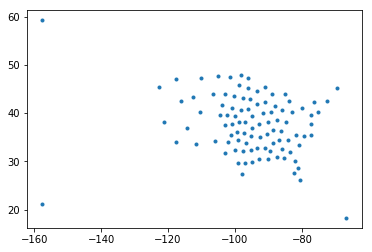

In [72]:
p = plt.scatter(dataset.iloc[:, 1], dataset.iloc[:, 0], marker='.')

plt.show()

So those are the centers of our 100 clusters.  With 60,000 total tornados, each
cluster represents about 600 tornados.  If we went with 1,000 clusters there 
would be about 60 tornados in each cluster.  But what is the optimum number of
clusters to use?